In [1]:
import numpy as np
import matplotlib.pyplot as plt

from linear import initial_distribution, transition_model, observation_model
from filters import sample_trajectory, kalman_filter, ensemble_kf, bootstrap_pf

save_figures = True

### 2.a
#### a.1

In [2]:
# Data
n_steps = 2000
a = 0.9
h = 1.3

# initial condition ~ N(mu0, sigma0)
mu0 = 0
sigma0 = 1

# conditional distribution ~ N(m, c)
m = 0
c = 0.5

# observation noise ~ N(0, gamma)
gamma = 0.1

# dynamical system parameters
p0 = initial_distribution(mu0, sigma0)
p = transition_model(a, m, c)
nu = observation_model(h, gamma)

In [3]:
np.random.seed(566)
u, y = sample_trajectory(n_steps, p0, p, nu)

In [4]:
plt.figure(figsize=(24, 8))
plt.plot(y, 'b', label='Observations', linewidth=1)
plt.plot(u, 'r', label='True trajectory', linewidth=1)
plt.xlabel('step')
plt.ylabel('system state')
plt.title('Sampled trajectory')
plt.legend(loc='upper left')
plt.show()

if save_figures:
    plt.savefig(f'figures/a1_sampled_trajectory.png')

np.float64(-7.187467688687664)

#### a.2

In [5]:
mean_kf, var_kf = kalman_filter(y, mu0, sigma0, a, m, c, h, gamma)
std_kf = var_kf ** 0.5

In [6]:
for xlim_left, xlim_right in [[0, n_steps / 10], [0, n_steps]]:
    plt.figure(figsize=(24, 8))
    plt.plot(mean_kf, 'b', label='Kalman filter', linewidth=1)
    plt.plot(mean_kf - std_kf, 'b:', linewidth=1)
    plt.plot(mean_kf + std_kf, 'b:', linewidth=1)
    plt.plot(y / h, 'g', label='Naive filter', linewidth=1)
    plt.plot(u, 'r', label='True trajectory', linewidth=1)
    plt.xlim(xlim_left, xlim_right)
    plt.xlabel('step')
    plt.ylabel('system state')
    plt.title('Estimated trajectory')
    plt.legend(loc='upper left')
    plt.show()

    if save_figures:
        plt.savefig(f'figures/a1_sampled_trajectory.png')

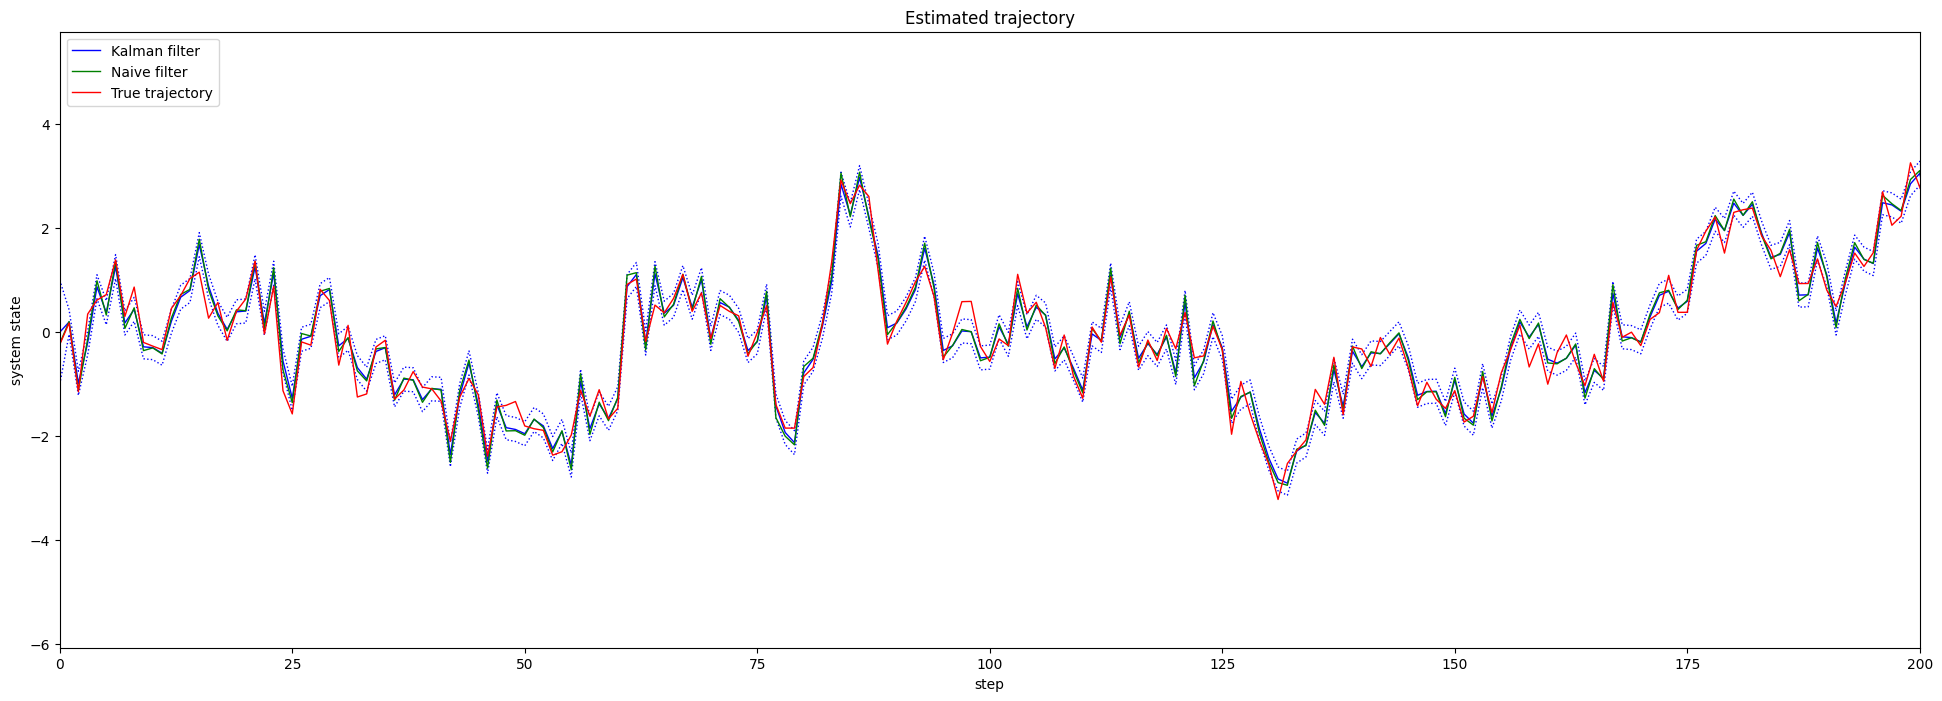

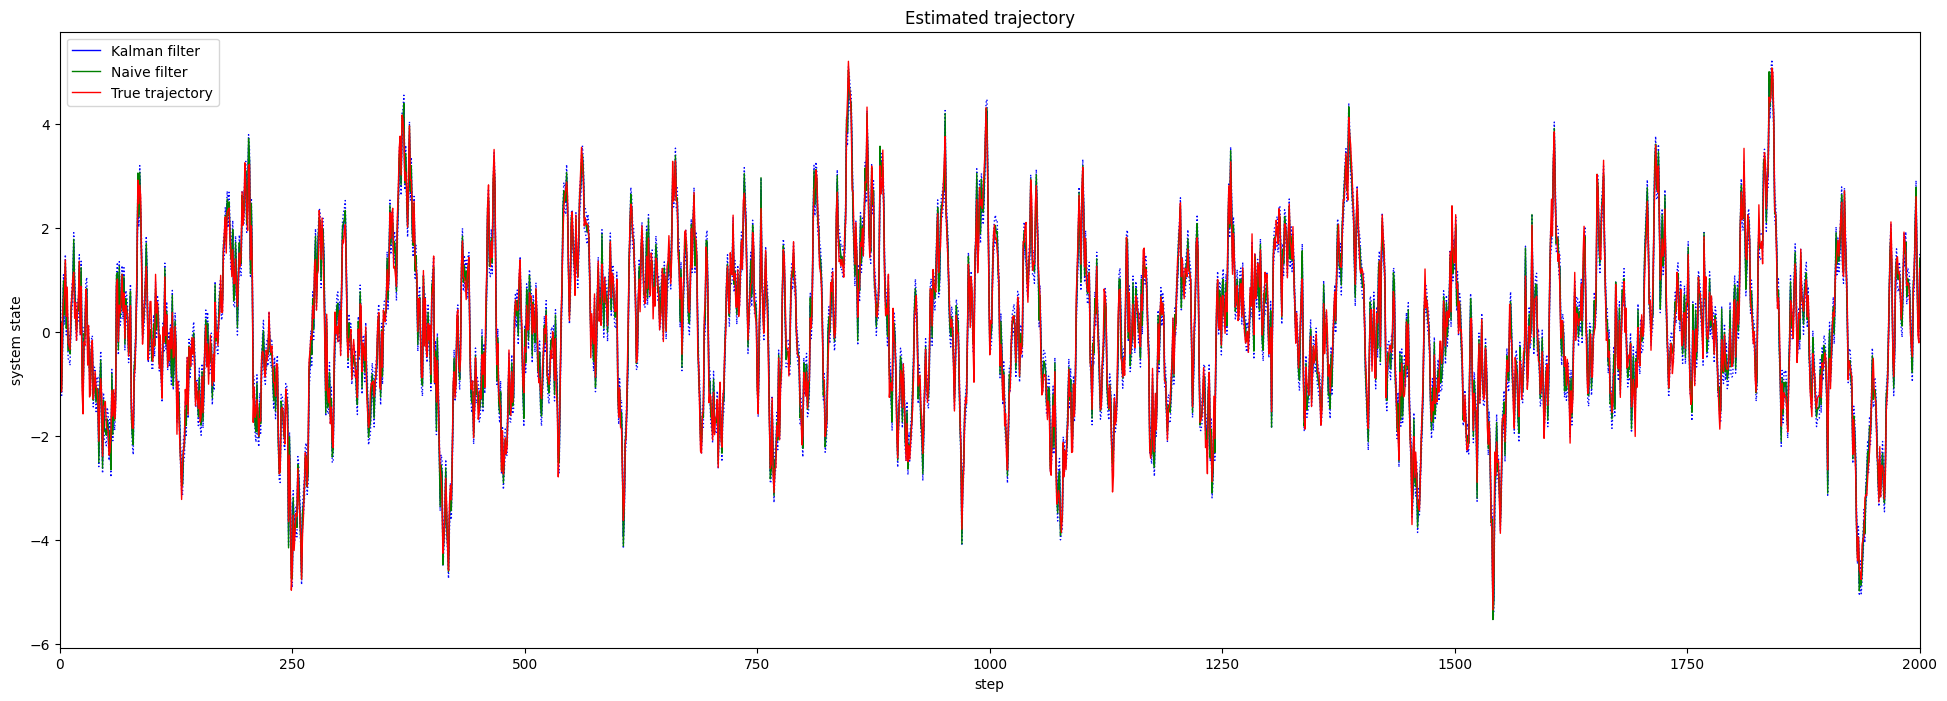

In [7]:
mse_kf = np.mean((mean_kf - u) ** 2 + var_kf)
mse_naive = np.mean((y / h - u) ** 2)
print(f'MSE (Kalman filter): {mse_kf:.4f}')
print(f'MSE (naive filter): {mse_naive:.4f}')

#### a.3

In [8]:
ns = [2 ** j for j in range(2, 9)]  # values of number of particles to try

In [9]:
mse_en = []
mean_en = []
std_en = []

for n_particles in ns:
    u_en = ensemble_kf(y, n_particles, p0, p, nu)

    mse_en.append(np.mean((u_en - u[:, np.newaxis]) ** 2))
    mean_en.append(np.mean(u_en, axis=1))
    std_en.append(u_en.std(axis=1))

for i in [0, len(ns) - 1]:
    for xlim_left, xlim_right in [[0, n_steps // 10], [0, n_steps]]:
        plt.figure(figsize=(24, 8))
        plt.plot(mean_en[i], 'c', label=f'Ensemble Kalman filter, N = {ns[i]}', linewidth=1)
        plt.plot((mean_en[i] - std_en[i]), 'c:', linewidth=1)
        plt.plot((mean_en[i] + std_en[i]), 'c:', linewidth=1)
        plt.plot(u, 'r', label='True trajectory', linewidth=1)
        plt.xlabel('step')
        plt.ylabel('system state')
        plt.title(f'Estimated trajectory for steps in [{xlim_left}, {xlim_right}]')
        plt.xlim(xlim_left, xlim_right)
        plt.legend(loc='upper left')
        plt.show()

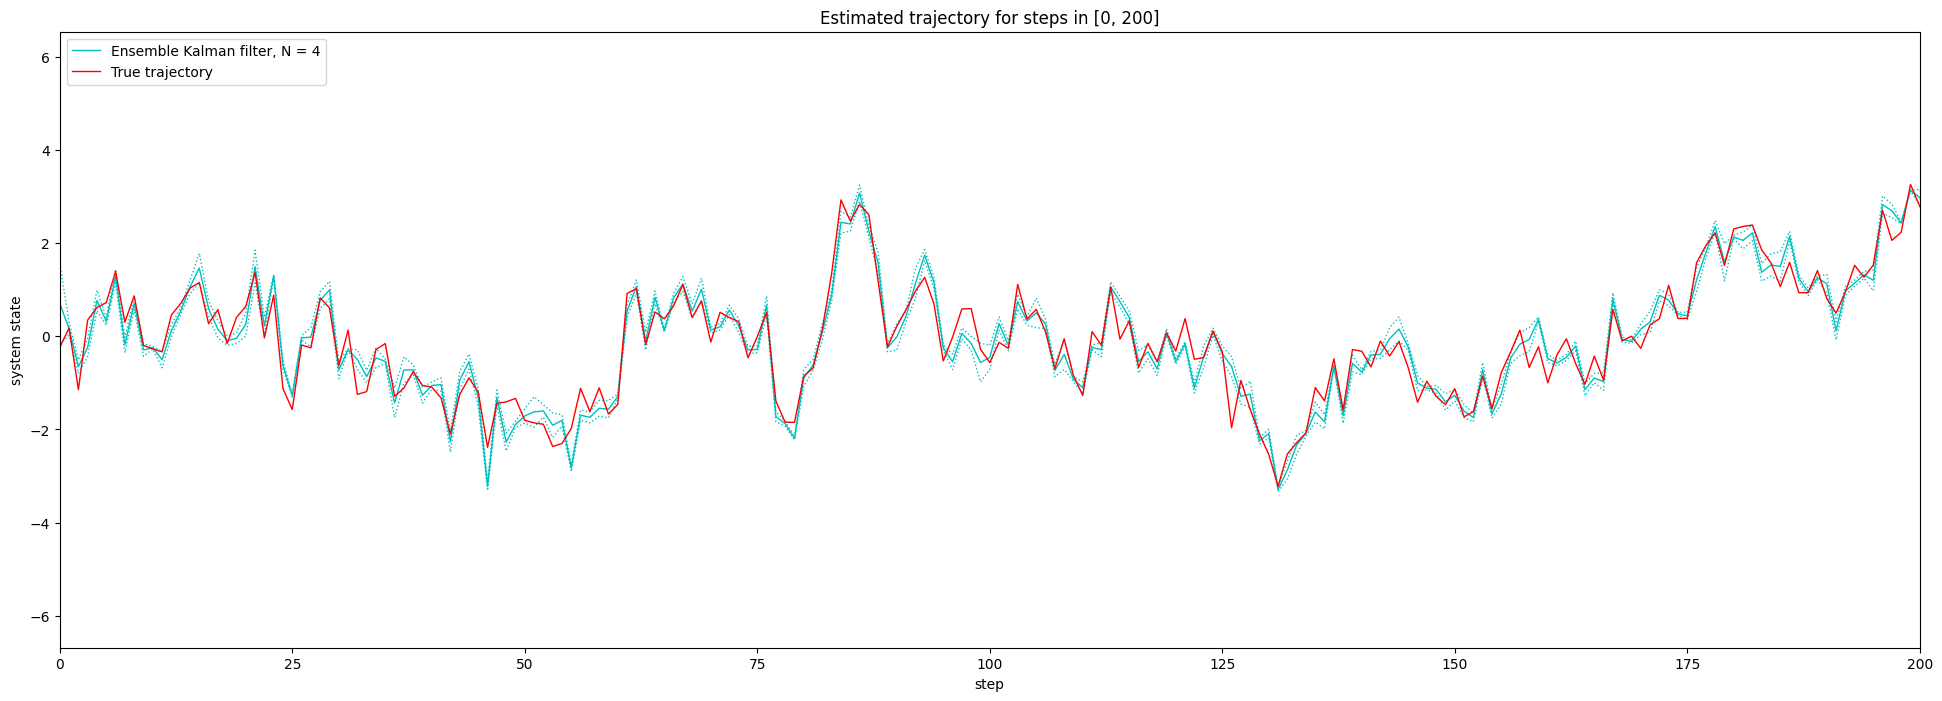

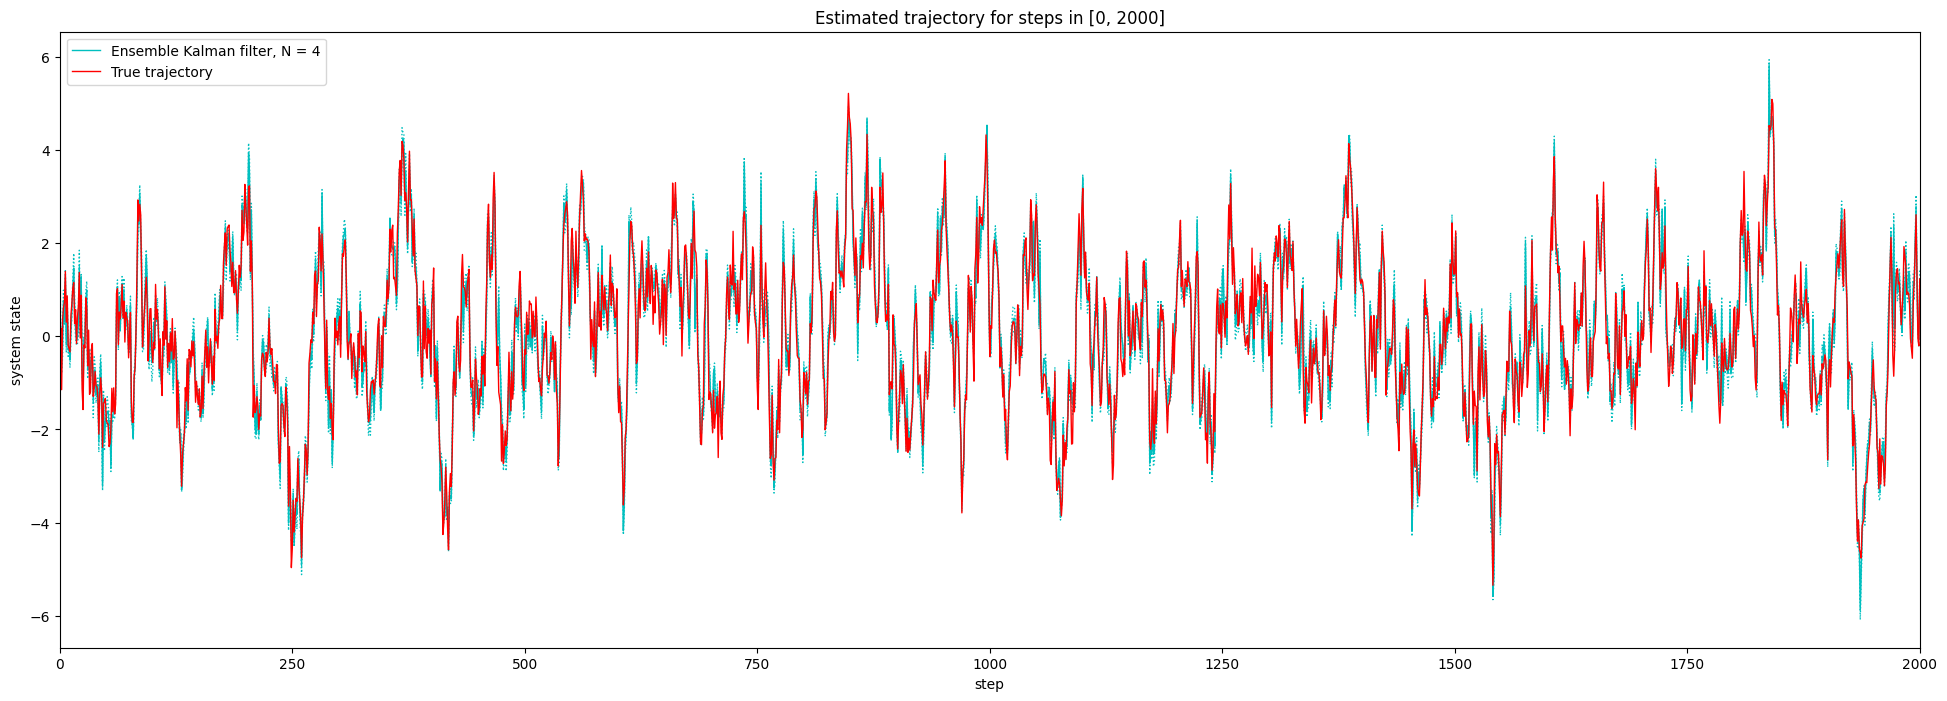

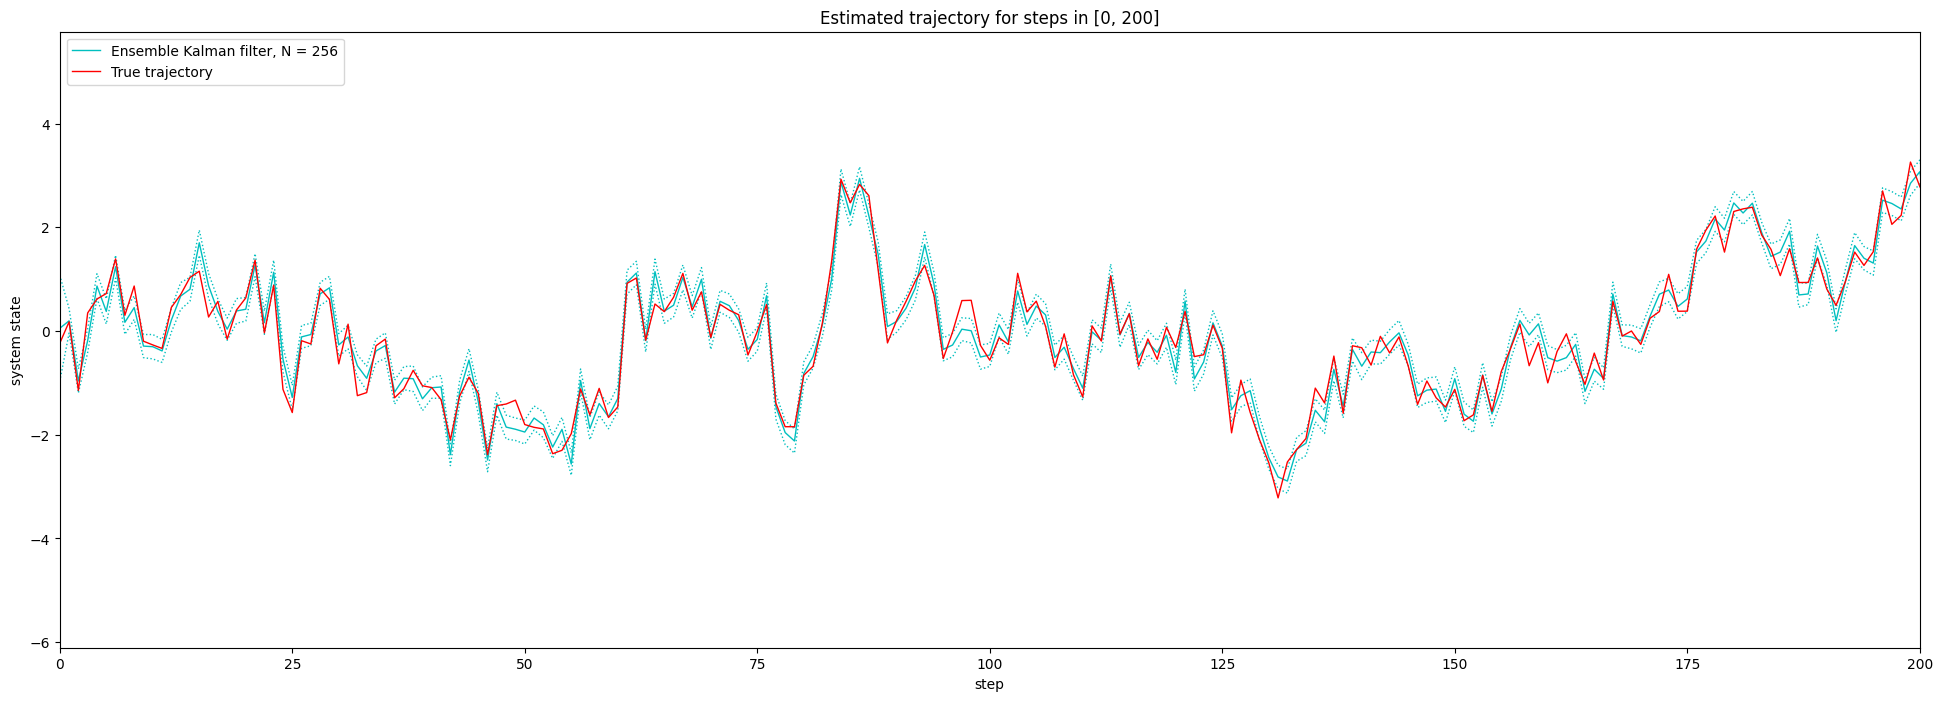

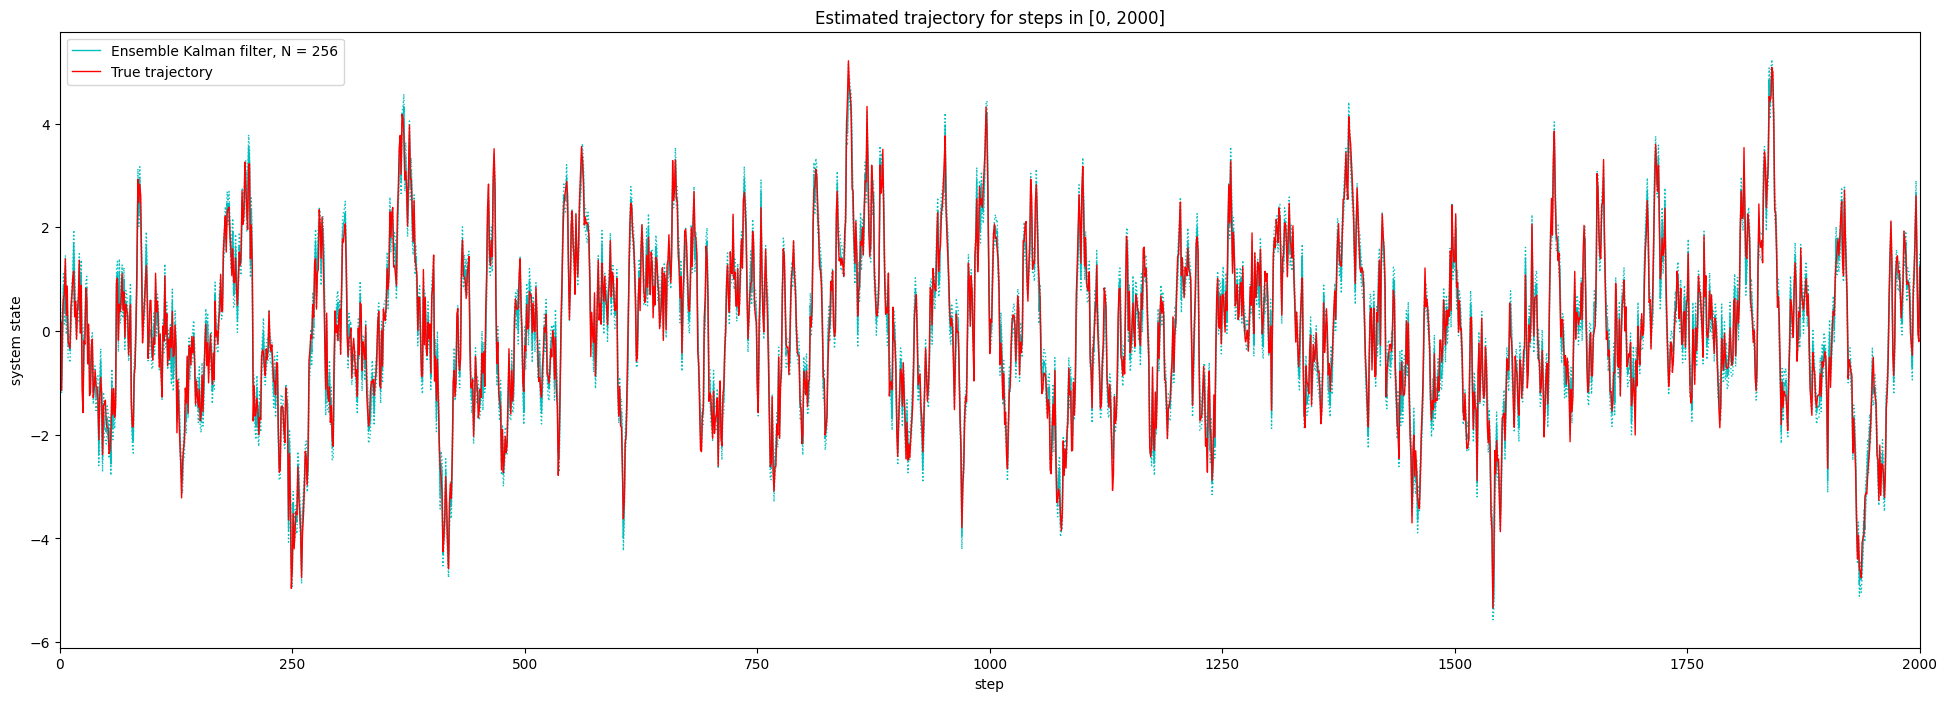

In [10]:
mse_bs = []
mean_bs = []
std_bs = []
ess_bs = []
ess_bs_no_resampling = []

for n_particles in ns:
    u_bs, w_bs, ess = bootstrap_pf(y, n_particles, p0, p, nu)

    mean = (w_bs * u_bs).sum(axis=1)
    std = (w_bs * (u_bs - mean[:, np.newaxis]) ** 2).sum(axis=1) ** 0.5

    mse_bs.append(np.mean(np.sum(w_bs * (u_bs - u[:, np.newaxis]) ** 2, axis=1)))
    mean_bs.append(mean)
    std_bs.append(std)
    ess_bs.append(ess)

    _, _, ess_no_resampling = bootstrap_pf(y, n_particles, p0, p, nu, no_resampling=True)
    ess_bs_no_resampling.append(ess_no_resampling)

for i in [0, len(ns) - 1]:
    for xlim_left, xlim_right in [[0, n_steps / 10], [0, n_steps]]:
        plt.figure(figsize=(24, 8))
        plt.plot(mean_bs[i], 'm', label=f'Bootstrap particle filter, N = {ns[i]}', linewidth=1)
        plt.plot((mean_bs[i] - std_bs[i]), 'm:', linewidth=1)
        plt.plot((mean_bs[i] + std_bs[i]), 'm:', linewidth=1)
        plt.plot(u, 'r', label='true trajectory', linewidth=1)
        plt.xlabel('step')
        plt.ylabel('system state')
        plt.title(f'Estimated trajectory for steps in [{xlim_left}, {xlim_right}]')
        plt.xlim(xlim_left, xlim_right)
        plt.legend()
        plt.show()

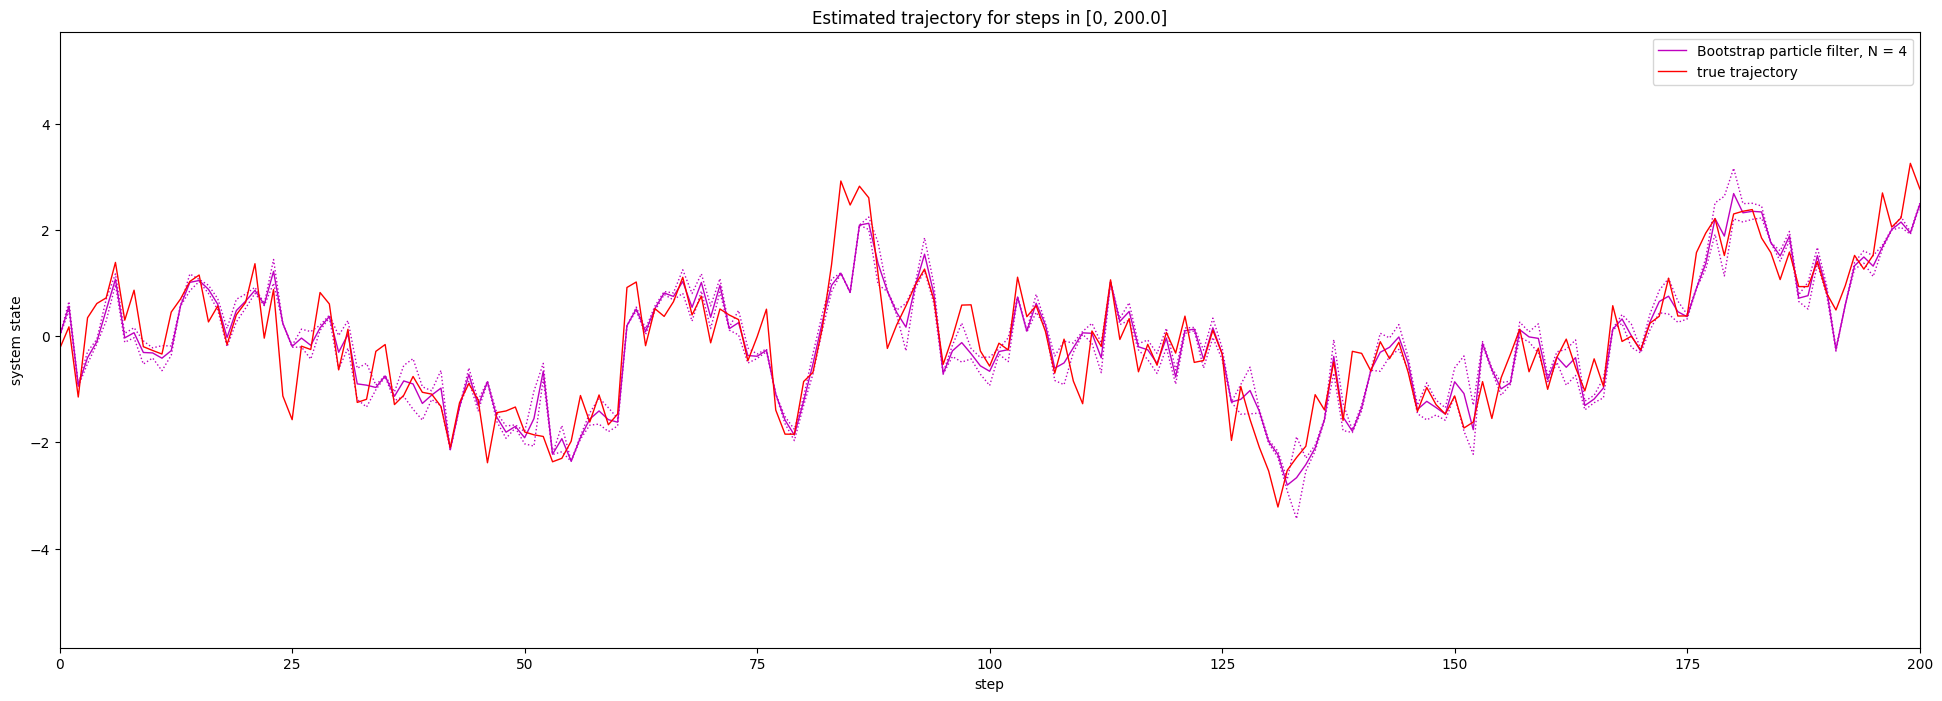

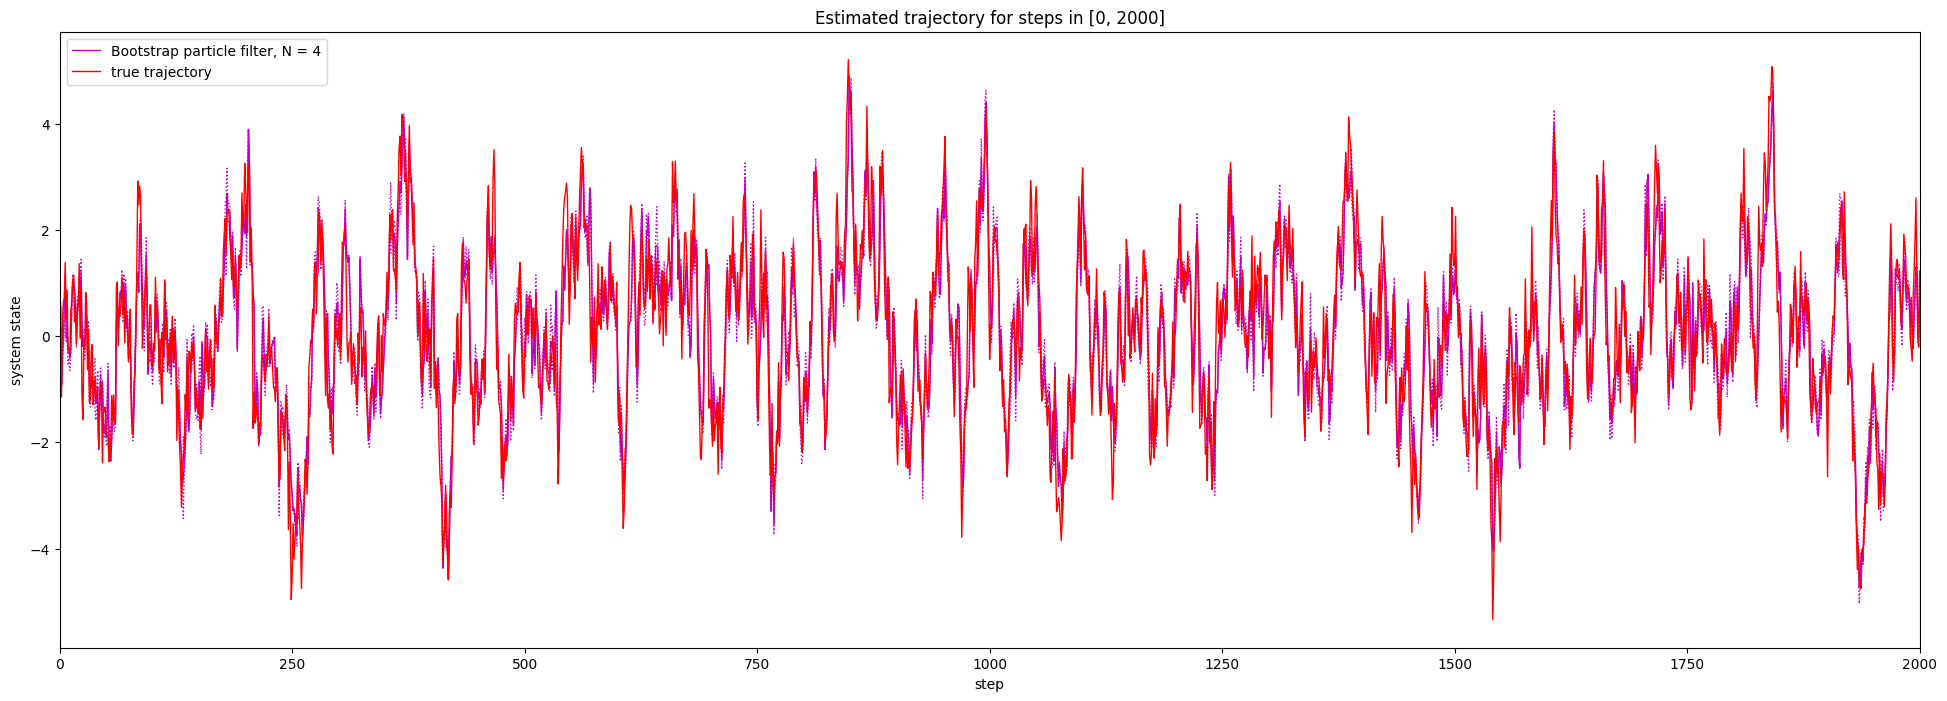

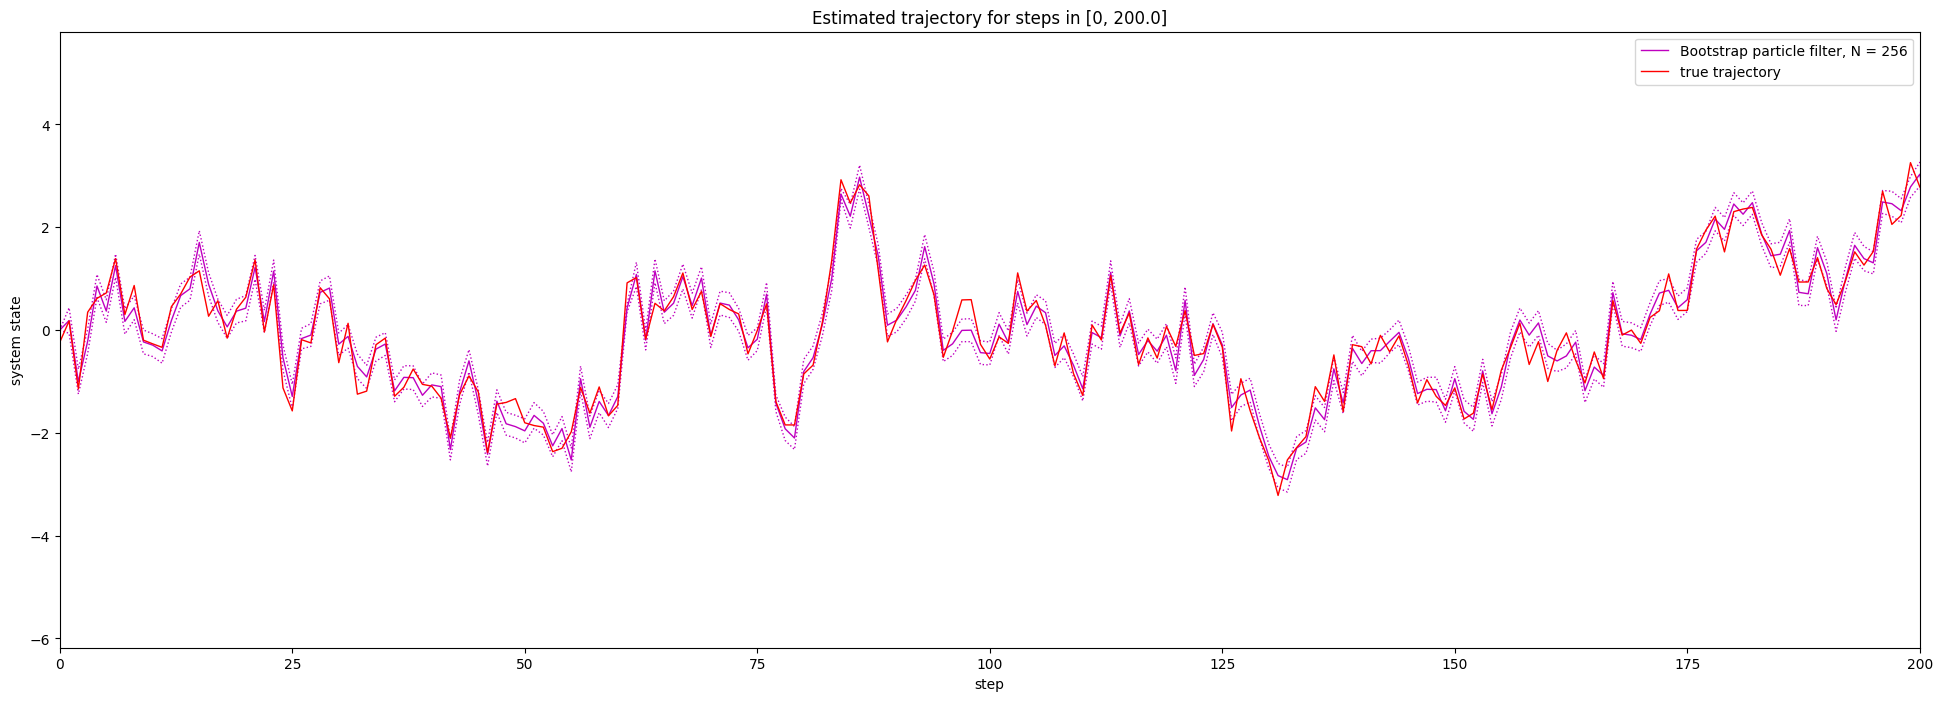

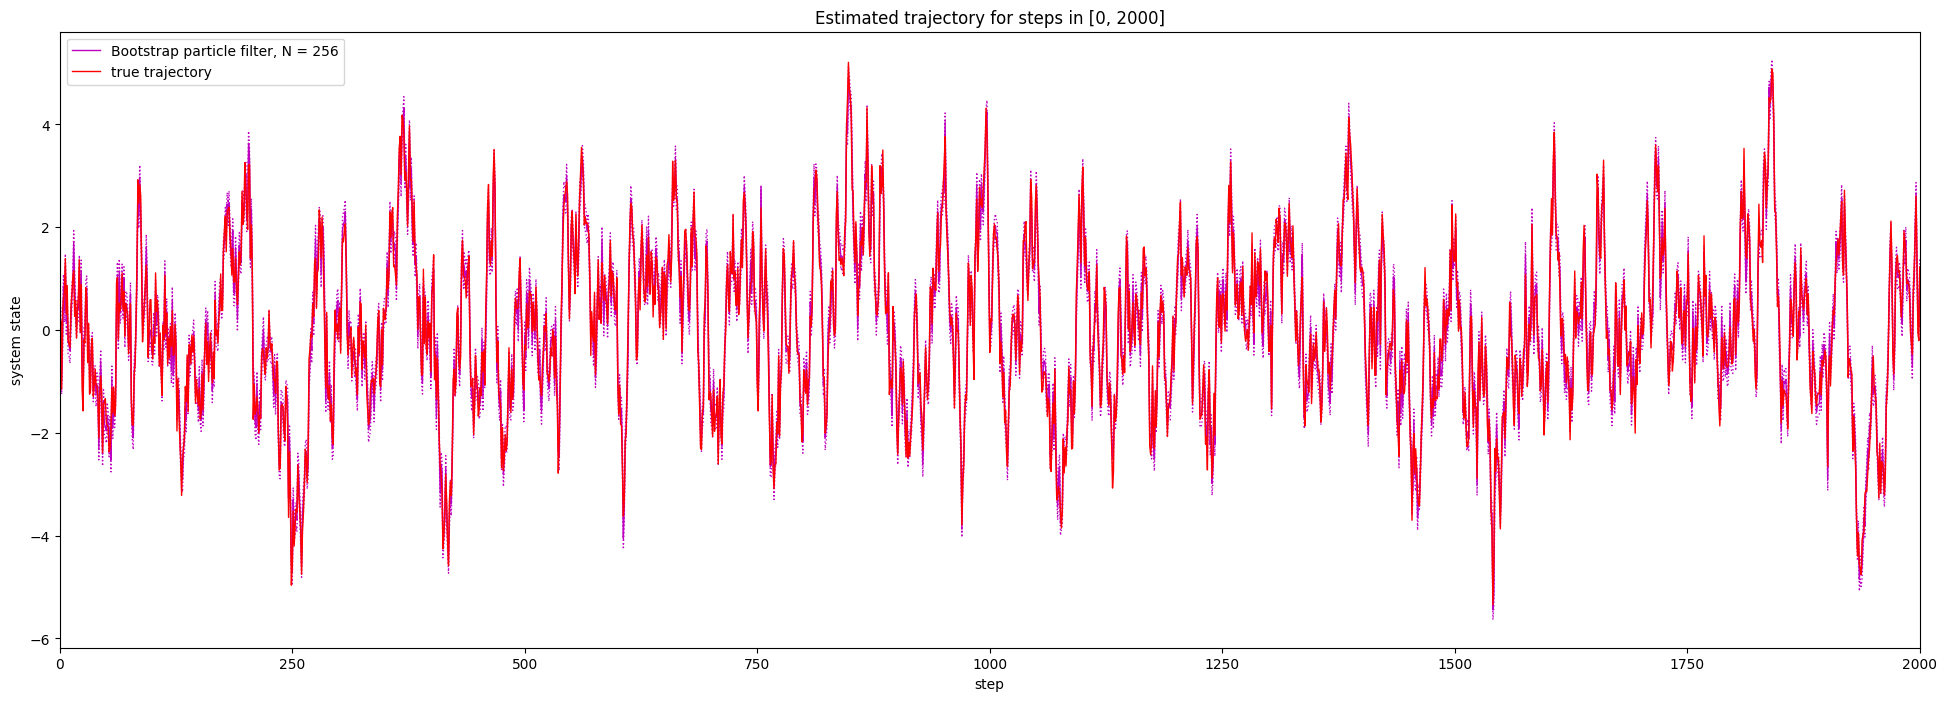

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(ns, np.repeat(mse_naive, len(ns)), 'g', label='Naive filter')
plt.plot(ns, np.repeat(mse_kf, len(ns)), 'b', label='Kalman filter')
plt.plot(ns, mse_en, 'c', label='Ensemble Kalman filter')
plt.plot(ns, mse_bs, 'm', label=f'Bootstrap particle filter')
plt.xlabel('number of particles')
plt.ylabel('MSE')
plt.title('Integrated MSE')
plt.legend(loc='upper right')
plt.show()

#### a.4

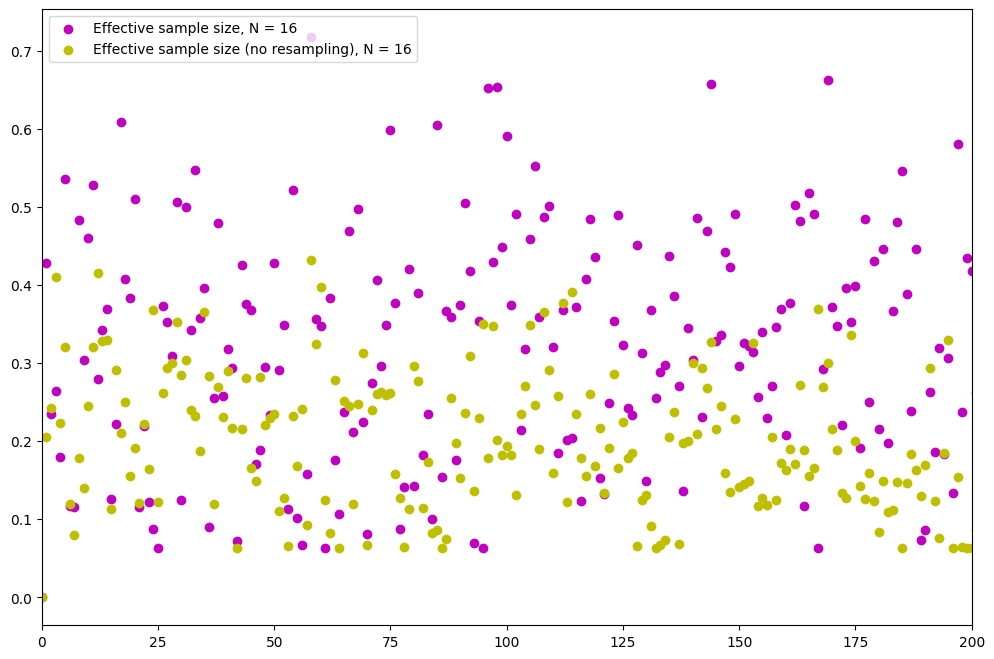

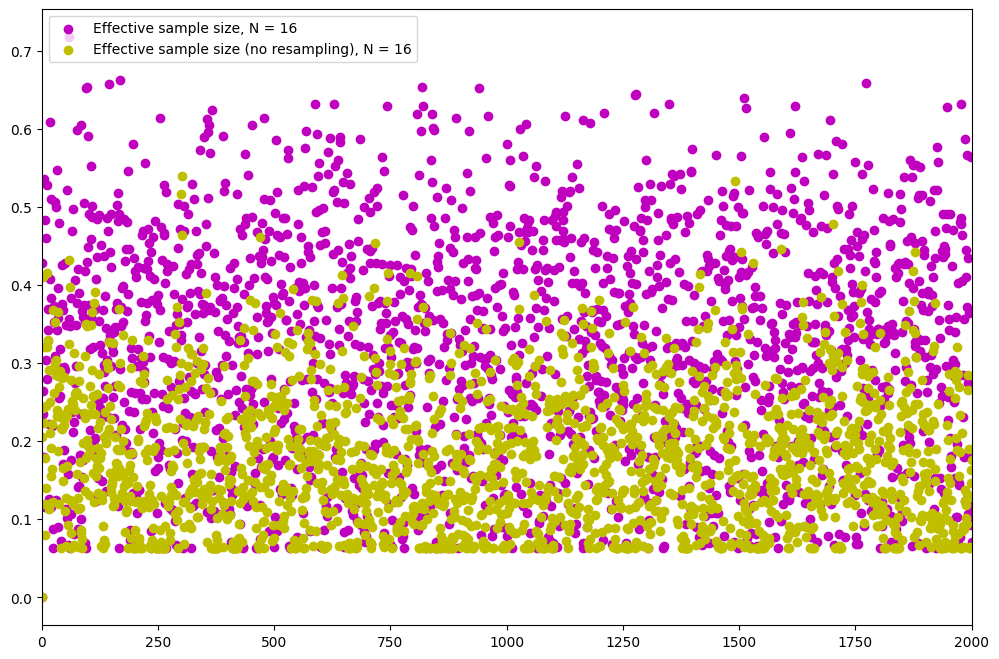

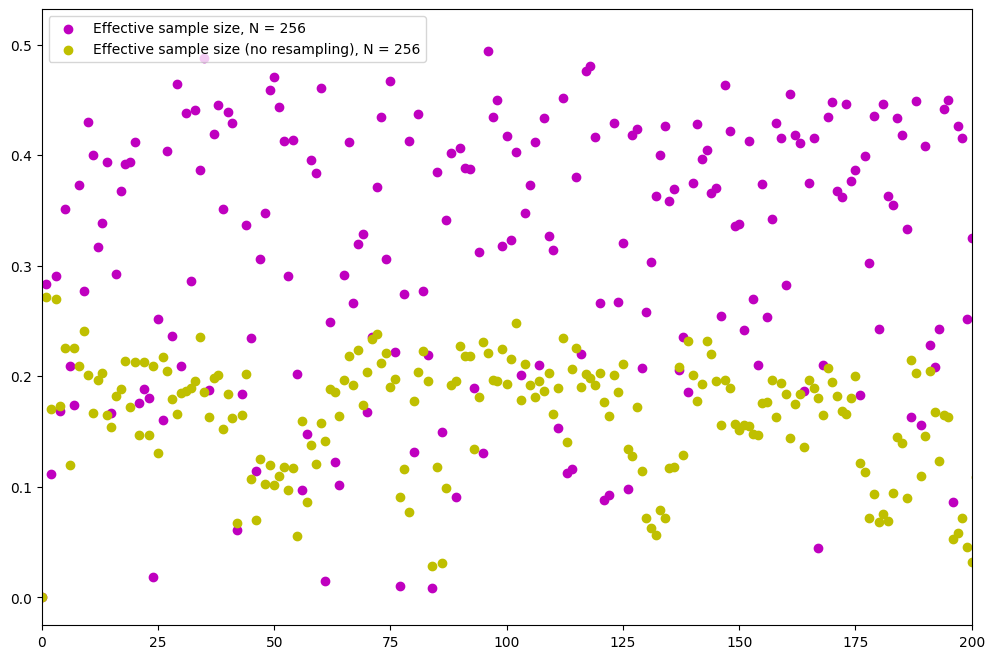

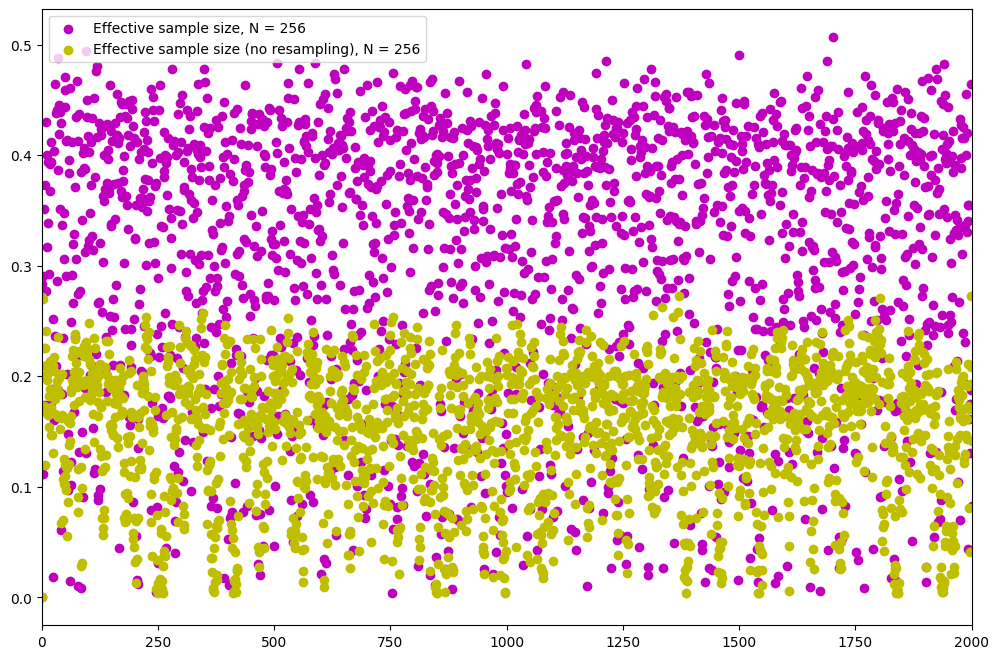

In [12]:
for i in [2, len(ns) - 1]:
    for xlim_left, xlim_right in [[0, n_steps / 10], [0, n_steps]]:
        plt.figure(figsize=(12, 8))
        plt.scatter(np.arange(n_steps + 1), ess_bs[i], color='m', label=f'Effective sample size, N = {ns[i]}',
                    linewidth=1)
        plt.scatter(np.arange(n_steps + 1), ess_bs_no_resampling[i], color='y',
                    label=f'Effective sample size (no resampling), N = {ns[i]}', linewidth=1)
        plt.xlim(xlim_left, xlim_right)
        plt.legend(loc='upper left')
        plt.show()